# 1vs1 results processing

In this section we process the results from the 1vs1 approach. We have run several simulations, using both statevector and qasm simulator (even including a noise model from a real quantum computer), for two different cost functions: train error and cross entropy. 

We first need to define the words, sentences and corresponding circuits of our dataset analogously to how it was done for the code with the simulations sentiment_analysis_1vs1.ipynb (check it out for a more detailed description).

## 1. Dataset prepartion

### 1.1. Define the vocabulary. 

In [1]:
import numpy as np
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)
# adjectives
morose, irascible = Word('morose', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, joyful = Word('terrified', n @ n.l), Word('joyful', n @ n.l)
downcast, miserable = Word('downcast', n @ n.l), Word('miserable', n @ n.l)
old, young = Word('old', n @ n.l), Word('young', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)
# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
entertains, irritates = Word('entertains', n.r @ s @ n.l), Word('irritates', n.r @ s @ n.l)

nouns = [man, woman, kid]
adjectives = [morose, irascible, frightened, cheerful, gloomy, furious, terrified, joyful, downcast, miserable, old, young]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles, entertains, irritates]

vocab = nouns + int_verbs + t_verbs + adjectives

### 1.2. Define the grammar

In [3]:
from discopy import Cup, Id, pregroup

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'ADJ_N_TV_N': Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_ADJ_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences (without adjective)
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}


# Transitive sentences (with adjective)
parsing_tra_ladj = {"{} {} {} {}.".format(adj, subj, t_verb, obj):  adj @ subj @ t_verb @ obj >> grammar_dict['ADJ_N_TV_N']
            for adj in adjectives for subj in nouns for t_verb in t_verbs for obj in nouns}
parsing_tra_radj = {"{} {} {} {}.".format(subj, t_verb, adj, obj):  subj @ t_verb @ adj @ obj >> grammar_dict['N_TV_ADJ_N']
            for subj in nouns for t_verb in t_verbs for adj in adjectives for obj in nouns}

parsing_tra.update(parsing_tra_ladj) #merges transitive adjectives into original dict
parsing_tra.update(parsing_tra_radj)

sentences_tra = list(parsing_tra.keys())
for sentence in sentences_tra:
    diagram = parsing_tra[sentence]
    data_psr[sentence] = parsing_tra[sentence]

### 1.3. Process the data

In [4]:
with open('sentiment_analysis_dataset.txt') as f:
    data = f.readlines()

In [5]:
from sklearn.model_selection import train_test_split
labels_dict = {}
data_psr_dict = {}
sent_type = {}

adjective_words = [a.name for a in adjectives]
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        if len(sentstr.split()) == 4:
            if sentstr.split()[0] in adjective_words:
                sent_type[sentstr] = 'tra_' + 'l'
            else:
                sent_type[sentstr] = 'tra_' + 'r'
        else:
            sent_type[sentstr] = 'tra'

Let us optimize the parsing.

In [6]:
# Code of this cell addapted from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

from discopy import Cap, Box

data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif 'tra' in sent_type[sentstr]:
        if sent_type[sentstr] == 'tra':
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[2].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_l': #adjective at beginning
            noun1 = Box(words[1].name, n.l, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['ADJ_N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_r': #adjective on second noun
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_ADJ_N']
            data_new_psr_dict[sentstr] = sentence.normal_form() 

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [7]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

## 2. Words to quantum circuits

Associate a variational quantum circuit (ansatz) to the words of the dataset.

In [8]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#*****************************************************
# Translation to quantum circuits
#*****************************************************

from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial
from discopy.quantum.gates import Rx, Rz

q_s = 1 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz
p_n = 3 # number of parameters for the single qubit iqp ansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

#-----------------------------------------
# parametrised part of ansaetze
#-----------------------------------------

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)     
    
def ansatz_state(state, params):
    arity = sum(ob[Ty(factor.name)] for factor in state.cod) 
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params): 
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

#----------------------------------------------------------
# Define parametrised functor to quantum circuits
#----------------------------------------------------------def F(params): 
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})  # send the effect with n.l to same quantum effect
    return Functor(ob_cqmap, ar)

In [9]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            parshapes.append((depth, arity-1))
    return parshapes

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i])))) # np.ravel flattens an array
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [10]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     33


## 3. Obtain test set

The next step is to obtain the test set from the total dataset. The binary datasets for each classifier are obtained from the training set from the train_test_split using random_state = 42 (we set it so we have the same division, but it could be changed as long as we make sure that the training and test set do not overlap). The test size is 0.25.

In [11]:
from sklearn.model_selection import train_test_split

psr_diagrams = []
psr_diagrams_dict = {}
psr_labels = []
sentences = []

for sentstr in data_new_psr_dict.keys():
    sentences.append(sentstr)
    diagram = data_new_psr_dict[sentstr]
    psr_diagrams.append(diagram)
    psr_diagrams_dict[sentstr] = diagram
    if labels_dict[sentstr] == '0':
        label = np.array([1,0,0,0])
    elif labels_dict[sentstr] == '1':
        label = np.array([0,1,0,0])
    elif labels_dict[sentstr] == '2':
        label = np.array([0,0,1,0])
    elif labels_dict[sentstr] == '3':
        label = np.array([0,0,0,1])
    psr_labels.append(label)

train_data_psr, test_data_psr, train_labels, test_labels = \
    train_test_split(psr_diagrams, psr_labels, test_size=0.25, random_state=42)
train_sent, test_sent, train_labels_sent, test_labels_sent = \
    train_test_split(sentences, psr_labels, test_size=0.25, random_state=42)

## 4. Define functions to obtain the results

In this section we define the necessary functions to obtain the results.

In [12]:
from qiskit import BasicAer, Aer, execute, ClassicalRegister
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

C:\Users\Paula\Anaconda3\envs\qnlp\lib\site-packages\qiskit\aqua\operators\operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


First, it is necessary to process the given dataset txt file so we can obtain the correspondent parsing diagrams, labels, sentences and sentence type.

In [14]:
def process_dataset(dataset):
    """ Process a QNLP dataset.
    
    Args:
        dataset: txt dataset to be processed.
    
    Returns:
        psr_diagrams: parsing diagrams.
        psr_labels: labels.
        sentences: sentences.
        sent_type: dictionary with the sentence type for each sentence.
    """
    with open(dataset) as f:
        data = f.readlines()
    labels_dict = {} # Dictionary with the labels for each sentence
    data_psr_dict = {} # Dictionary with the parsing for each sentence
    sent_type = {} # Dictionary with the sentence type for each sentence
    # Create the previous dictionaries from the given dataset
    adjective_words = [a.name for a in adjectives]
    for sentence in data:
        sentstr = sentence[:-7]
        if sentence[-6:-3] == 'int':
            diagram = parsing_int[sentstr]
            data_psr_dict[sentstr] = diagram
            labels_dict[sentstr] = sentence[-2]
            sent_type[sentstr] = 'int'
        elif sentence[-6:-3] == 'tra':
            diagram = parsing_tra[sentstr]
            data_psr_dict[sentstr] = diagram
            labels_dict[sentstr] = sentence[-2]

            if len(sentstr.split()) == 4:
                if sentstr.split()[0] in adjective_words:
                    sent_type[sentstr] = 'tra_' + 'l'
                else:
                    sent_type[sentstr] = 'tra_' + 'r'
            else:
                sent_type[sentstr] = 'tra'  
    # Rearrange the parsing of the diagrams
    data_new_psr_dict = {}
    for sentstr in data_psr_dict.keys():
        num_words = len(sentstr.split(' '))
        words = data_psr_dict[sentstr].boxes[:num_words]
        if sent_type[sentstr] == 'int':
            noun = Box(words[1].name, n.l, Ty()) 
            words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2]) # Rearranged words
            sentence = words_new >> grammar_dict['ADJ_N_IV'] # Apply grammar on rearranged words
            data_new_psr_dict[sentstr] = sentence.normal_form() # Store sentece with optimum diagram
        elif 'tra' in sent_type[sentstr]:
            if sent_type[sentstr] == 'tra':
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[2].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['N_TV_N']
                data_new_psr_dict[sentstr] = sentence.normal_form()
            elif sent_type[sentstr] == 'tra_l': #adjective at beginning
                noun1 = Box(words[1].name, n.l, Ty())
                noun2 = Box(words[3].name, n.l, Ty())
                words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['ADJ_N_TV_N']
                data_new_psr_dict[sentstr] = sentence.normal_form()
            elif sent_type[sentstr] == 'tra_r': #adjective on second noun
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[3].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['N_TV_ADJ_N']
                data_new_psr_dict[sentstr] = sentence.normal_form() 
    # Store the diagrams, labels and sentences for the classification
    psr_diagrams = []
    psr_diagrams_dict = {}
    psr_labels = []
    sentences = []
    for sentstr in data_new_psr_dict.keys():
        sentences.append(sentstr)
        diagram = data_new_psr_dict[sentstr]
        psr_diagrams.append(diagram)
        psr_diagrams_dict[sentstr] = diagram
        if labels_dict[sentstr] == '0':
            label = np.array([1,0])
        elif labels_dict[sentstr] == '1':
            label = np.array([0,1])
        psr_labels.append(label)
        
    return psr_diagrams, psr_labels, sentences, sent_type

Once the dataset has been processed, we obtain the final parameters from the QNLP algorithm, that are returned by the SPSA classical optimizer. We can also obtain the cost for each iteration averaging over the cost evaluated for the params_plus and params_minus of the SPSA optimizer https://www.jhuapl.edu/spsa/#Settings. This way we have an estimate of the cost evaluated at the exact parameters resulting from each iteration and avoid the cost of evaluating the cost an extra time for iteration. This is very noticeable for the performance of our algorithm, since in fact, in each evaluation of the cost function we are measuring hundreds of quantum circuits.

In [15]:
def get_cost_and_final_params(file):
    """ Get cost and finals params of a simulation file.
    
    Args:
        file = pickle simulation file.
        
    Returns:
        cost = cost of the training.
        final_params = final parameters.
    """
    # Load file with the results
    with open(file, "rb") as fp:  
        data = pickle.load(fp)
    # Store final params
    final_params = data[0][0]
    # Process stored cost
    cost_data = data[1][:-1]
    cost_save_plus = []
    cost_save_minus = []
    for j in range(0,len(cost_data)):
        if j % 2:
            cost_save_plus.append(cost_data[j])
        else:
            cost_save_minus.append(cost_data[j])
    cost_save_plus = np.asarray(cost_save_plus)
    cost_save_minus = np.asarray(cost_save_minus)
    cost = 0.5 * (cost_save_plus+cost_save_minus)
    return cost[25:], final_params    

To evaluate the circuits for the final value of the parameters of the optimization, we define the following function, that allows us to use different backends, according to what is being simulated: statevector, qasm or noisy qasm. For the evaluation in a real IBMQ device, the backend must be changed to the desired one.

In [13]:
def get_qiskit_results(circ, s_type, retries=10, qasm=False, noise_model=None, 
                       basis_gates=None, coupling_map=None, max_shots=8192):
    """Function to get the Qiskit's results from a DisCoPy circuit.
    
    Args:
        circ = DisCoPy circuit.
        s_type = sentence type for the sentence associated to the circuit.
        retries = number of retries before assigning a random result
            if the postselection leads to zero values (Default is 10).
        qasm = if True qasm_simulator is used, if not statevector_simulator
            (Default is False).
        noise_model = Qiskit's noise model object (Default is None).
        basis_gates = basis gates of the device (Default is None).
        coupling_map = coupling_map of the device (Default is None).
        max_shots = number of shots (Default is 8192).
        
            
    Returns:
        array: results from the postselection measurement.
    """
    
    # Select qubits for postselection according to the sentence type    
    
    if s_type == 'int':
        n_qubits = 4
        post = 2
    elif s_type == 'tra':
        n_qubits = 3
        post = 1
    elif s_type == 'tra_l':
        n_qubits = 5
        post = 2
    else:
        assert s_type == 'tra_r'
        n_qubits = 5
        post = 1
    
    # From DisCoPy to Qiskit circuit    
    qc = tk_to_qiskit(circ.to_tk())
    if qasm == True:
        #qasm_simulator
        out_reg = ClassicalRegister(1)
        qc.add_register(out_reg)
        qc.measure(post, out_reg[0]) 
        if noise_model is not None:
            backend = Aer.get_backend('qasm_simulator')
            # Include noise model
            results = execute(qc, backend, shots=max_shots, noise_model=noise_model, 
                              coupling_map=coupling_map,basis_gates=basis_gates).result().get_counts()
        else:
            backend = BasicAer.get_backend('qasm_simulator')
            results = execute(qc, backend, shots=max_shots).result().get_counts()

        zeros = '0' * (n_qubits - 1)

        if '0 ' + zeros not in results and '1 ' + zeros not in results:
            if retries == 0:
                return np.random.rand(2)
            return get_qiskit_results(circ, s_type, retries=retries-1, qasm = qasm,
                                     noise_model=noise_model, coupling_map=coupling_map,
                                     basis_gates=basis_gates, max_shots=max_shots)

        return parse_results(results, eff=zeros)
    
    else:
        # statevector_simulator
        qc.remove_final_measurements()
        state_dict = Statevector(qc).to_dict()
        post0, post1 = '0' * n_qubits, '0' * n_qubits
        post1 = post1[:post] + '1' + post1[post + 1:]
        return [np.abs(state_dict[post0])**2, np.abs(state_dict[post1])**2]


def parse_results(results, eff='0'):
    """Parse results of qasm_simulator.
    
    Args:
        results: counts from quantum circuit's measurement.
        eff: digits for splitting the results for post selection.
        
    Returns:
        array: post selected results.
    """
    ks = [k for k in results.keys() if k.split()[1] == eff]
    post_selected_results = {k.split()[0]:v for (k,v) in results.items() if k in ks}
    
    if '0' not in post_selected_results:
        post_selected_results['0'] = 0
    if '1' not in post_selected_results:
        post_selected_results['1'] = 0
        
    total = post_selected_results['0'] + post_selected_results['1']
    
    assert total > 0, 'total was 0 after postselection - try running with more shots'
    
    
    return [post_selected_results['0']/total,  post_selected_results['1']/total]

Once we know how to process the dataset and to obtain the results from the measurements of quantum circuits, we can obtain the predictions for both the training and the test set, using the final optimum parameters from the optimization.

In [17]:
def obtain_train_predictions(final_params,train_data_cla, train_labels_cla, 
                     train_sent_cla, sent_type, qasm=False, noise_model=None, 
                       basis_gates=None, coupling_map=None, max_shots=8192):
    """ Obtain train set predictions from the binary training 
    classifiers for 1vs1 classification.
    
    Args:
        final_params = final params for the optimization for each classifier.
        train_data_cla = list of the training circuits 
            for each classifier.
        train_labels_cla = list of the training labels
            for each classifier.
        train_sent_cla = list of the training sentences
            for each classifier.
        sent_type = dictionary sentences to sentence type.
        qasm = if True qasm_simulator is used, if not statevector_simulator
            (Default is False).
        noise_model = Qiskit's noise model object (Default is None).
        basis_gates = basis gates of the device (Default is None).
        coupling_map = coupling_map of the device (Default is None).
        max_shots = number of shots (Default is 8192).
        
    Returns:
        final_pred_test_results = test set predicted labels.
    """
    # Create list for train predictions of each classifier
    train_results_cla = []  
    for j in range(len(train_data_cla)):
        train_pred = []
        # Obtain train predicted results
        func = F(reshape_params(final_params[j], par_shapes))
        train_data_psr = train_data_cla[j]
        train_labels_psr = train_labels_cla[j]
        train_sent = train_sent_cla[j]
        final_train_circuits = [func(diag) for diag in train_data_psr]
        train_results = [get_qiskit_results(final_train_circuits[i], sent_type[train_sent[i]], qasm=qasm,
                                           noise_model=noise_model, coupling_map=coupling_map,
                                           basis_gates=basis_gates, max_shots=max_shots) for i in range(len(train_sent))]
        train_results_tweaked = [np.abs(np.array(res) - 1e-9) for res in train_results]
        pred_train_results = [res.flatten() / np.sum(res) for res in train_results_tweaked]
        for i, res in enumerate(pred_train_results):
            res = np.argmax(res)
            train_pred.append(res)
        train_results_cla.append(train_pred)
    return train_results_cla

def obtain_test_predictions(final_params, sent_type, test_data_psr,
                     test_sent, qasm=False, noise_model=None, 
                       basis_gates=None, coupling_map=None, max_shots=8192):
    """ Obtain test set predictions from the binary training 
    classifiers for 1vs1 classification.
    
    Args:
        final_params = final params for the optimization for each classifier.
        train_data_cla = list of the training circuits 
            for each classifier.
        train_labels_cla = list of the training labels
            for each classifier.
        train_sent_cla = list of the training sentences
            for each classifier.
        sent_type = dictionary sentences to sentence type.
        test_data_psr = test data.
        test_sent = test_sentences.
        qasm = if True qasm_simulator is used, if not statevector_simulator
            (Default is False).
        noise_model = Qiskit's noise model object (Default is None).
        basis_gates = basis gates of the device (Default is None).
        coupling_map = coupling_map of the device (Default is None).
        max_shots = number of shots (Default is 8192).
        
    Returns:
        train_pred_results_cla = train set predicted labels for 
            each classifier.
        final_pred_test_results = test set predicted labels.
    """
    # Create list for test predictions of each classifier
    test_pred = [None]*len(test_data_psr)
    for i in range(len(test_data_psr)):
        test_pred[i] = np.zeros(4)     
    for j in range(len(train_data_cla)):
        func = F(reshape_params(final_params[j], par_shapes))
        # Obtain test predicted results
        final_test_circuits = [func(diag) for diag in test_data_psr]
        test_results = [get_qiskit_results(final_test_circuits[i], sent_type[test_sent[i]], qasm=qasm,
                                          noise_model=noise_model, coupling_map=coupling_map,
                                          basis_gates=basis_gates, max_shots=max_shots) for i in range(len(test_sent))]
        test_results_tweaked = [np.abs(np.array(res) - 1e-9) for res in test_results]
        pred_test_results = [res.flatten() / np.sum(res) for res in test_results_tweaked]
        # For the test results, add one for the element of the list test_pred
        # whose index correspond to the resulting label.
        for i, res in enumerate(pred_test_results):
            res = np.argmax(res)
            if j == 0:
                if res == 0:
                    test_pred[i][0] += 1
                elif res == 1:
                    test_pred[i][1] += 1
            elif j == 1:
                if res == 0:
                    test_pred[i][0] += 1
                elif res == 1:
                    test_pred[i][2] += 1
            elif j == 2:
                if res == 0:
                    test_pred[i][0] += 1
                elif res == 1:
                    test_pred[i][3] += 1
            elif j == 3:
                if res == 0:
                    test_pred[i][1] += 1
                elif res == 1:
                    test_pred[i][2] += 1
            elif j == 4:
                if res == 0:
                    test_pred[i][1] += 1
                elif res == 1:
                    test_pred[i][3] += 1
            elif j == 5:
                if res == 0:
                    test_pred[i][2] += 1
                elif res == 1:
                    test_pred[i][3] += 1 
    # Obtain the most common label as test result
    final_pred_test_results = []
    for res in test_pred:
        final_pred_test_results.append(select_label(res))
    return final_pred_test_results

In [16]:
import random

def select_label(res):
    """ Select label for test result.
    
    Args:
        res = test result for 1vs1 multi-class classification.
    
    Returns:
        int = test data predicted label"""
    indices = []
    max_label = max(res)
    for i, r in enumerate(res):
        if r == max_label:
            indices.append(i)
    # Choose the result randomly among the most common ones if they
    # appear an equal number of times.
    if len(indices) > 1 :
        return random.choice(indices)
    else:
        return indices[0]

## 5. Analyze the results

We are going to retrieve the results of the simulations and analyze them. We are going to use as figures of merit the cost, the confusion matrix and the accuracy of the results.

In [18]:
def print_accuracy(y_true, y_pred):
    """ Print the final accuracy and the accuracy for each label
    for set of predicted and true labels.
    
    Args:
        y_true = true labels.
        y_pred = predicted labels.
    """
    c_matrix = confusion_matrix(y_true, y_pred)
    labels = np.arange(c_matrix.shape[0])
    print('Total accuracy: ', sum(np.diag(c_matrix))/len(y_true))
    for label in labels:
        print(f'Accuracy label {label}: ', c_matrix[label,label]/sum(c_matrix[label,:]))

Let us now obtain the results for each simulation. All of the simulations have been performed using 2000 iterations and the IQP ansatz (with 3 parameters for the 1 qubit version). We group the simulations according to the cost function used, which allows us to compare the performance of the statevector and qasm simulators.

Let us now obtain the results for each simulation. All of the simulations have been performed using 2000 iterations for the SPSA optimizer and the IQP ansatz (with 3 parameters for the 1 qubit version). We group the simulations according to the cost function used, which allows us to compare the performance of the statevector and qasm simulators.

### 5.1. Cost function: train error

We choose the train error, the ratio of correct predicted train labels, as cost function.

In [19]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

Accuracy training set happy_vs_sad (statevector_simulator)
Total accuracy:  0.8923076923076924
Accuracy label 0:  0.9152542372881356
Accuracy label 1:  0.8732394366197183
Accuracy training set happy_vs_angry (statevector_simulator)
Total accuracy:  0.8175182481751825
Accuracy label 0:  0.9491525423728814
Accuracy label 1:  0.717948717948718
Accuracy training set happy_vs_scared (statevector_simulator)
Total accuracy:  0.824
Accuracy label 0:  0.9152542372881356
Accuracy label 1:  0.7424242424242424
Accuracy training set sad_vs_angry (statevector_simulator)
Total accuracy:  0.8657718120805369
Accuracy label 0:  0.9577464788732394
Accuracy label 1:  0.782051282051282
Accuracy training set sad_vs_scared (statevector_simulator)
Total accuracy:  0.8394160583941606
Accuracy label 0:  0.9436619718309859
Accuracy label 1:  0.7272727272727273
Accuracy training set angry_vs_scared (statevector_simulator)
Total accuracy:  0.8819444444444444
Accuracy label 0:  0.9358974358974359
Accuracy label 1: 

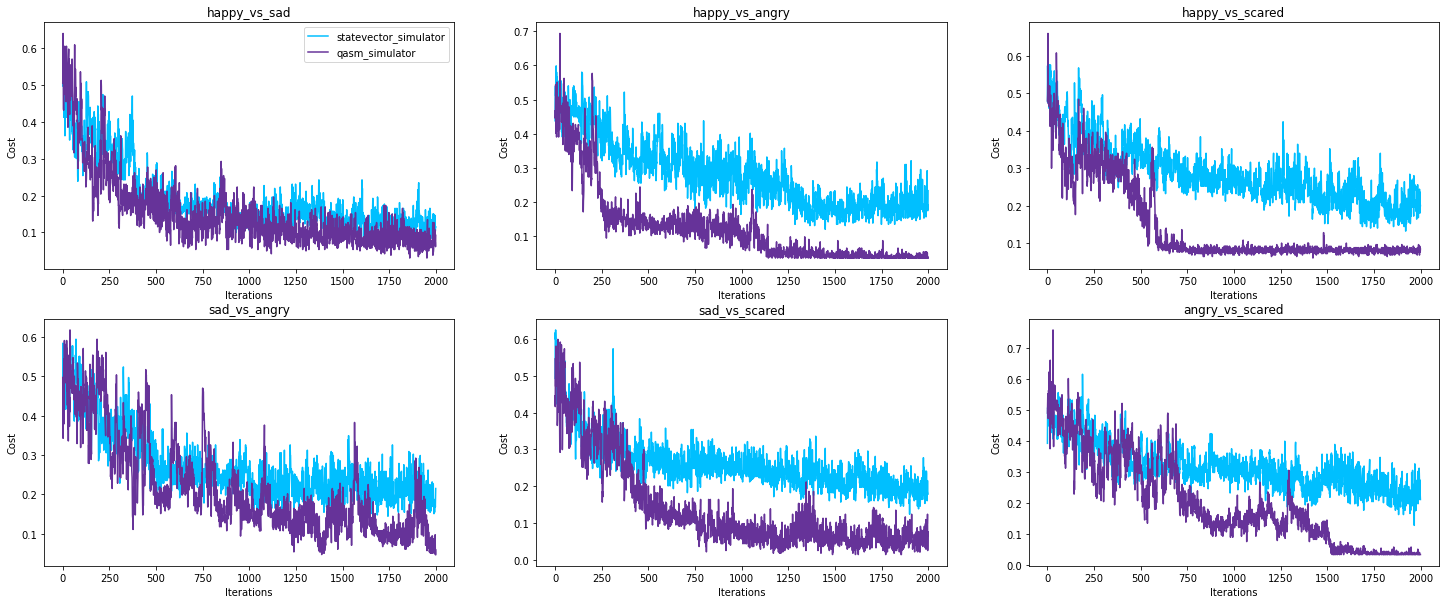

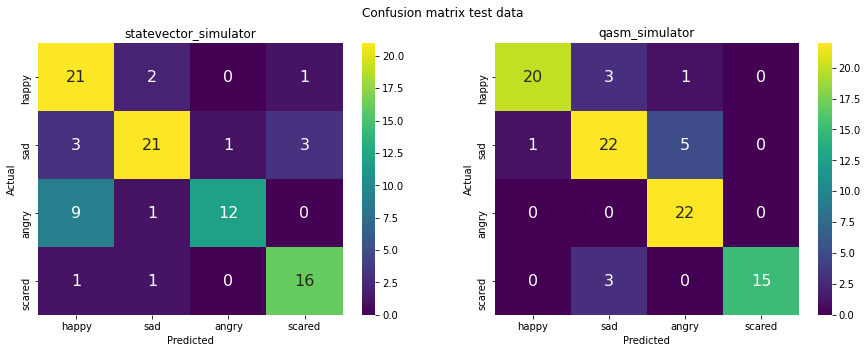

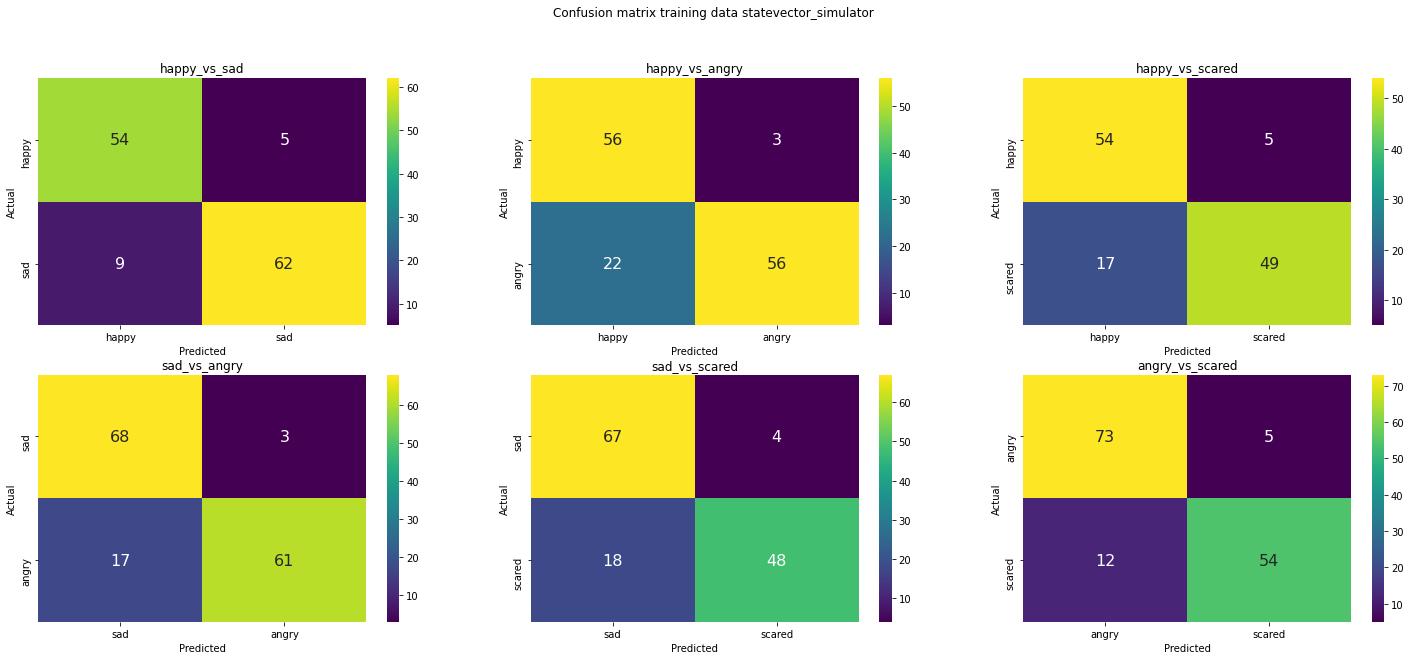

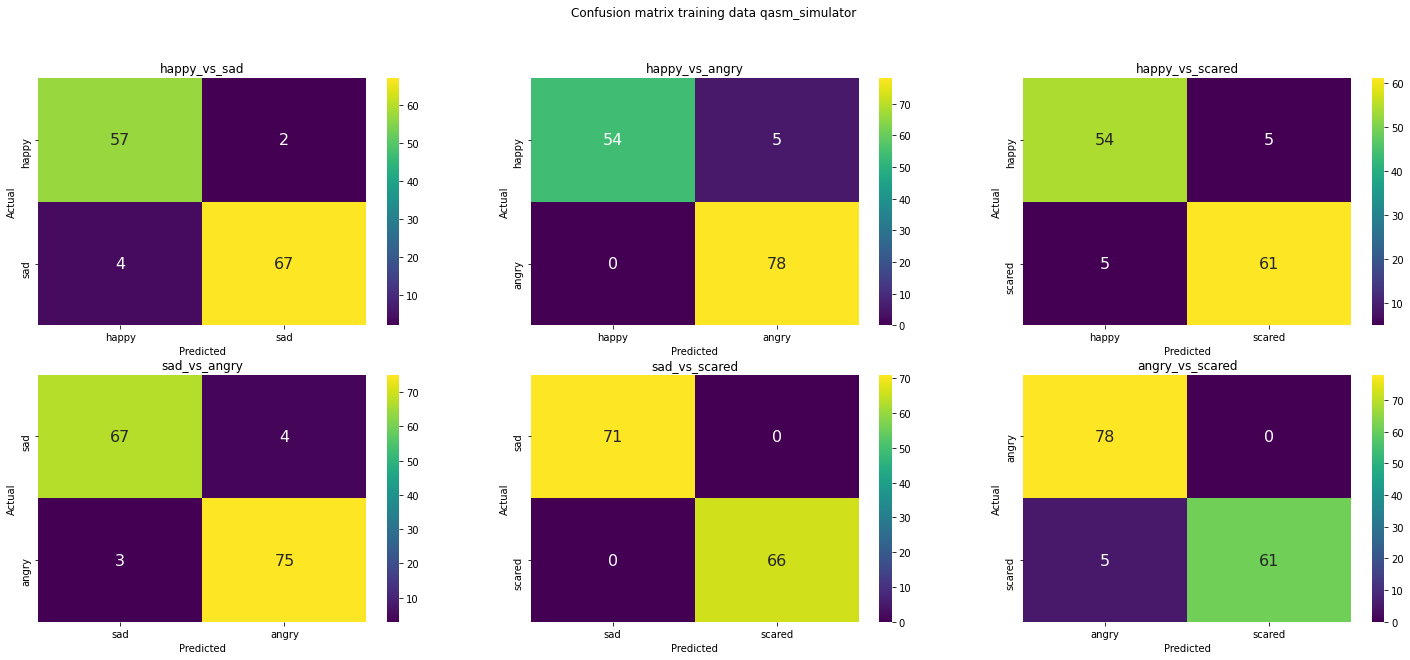

In [33]:
# Define the binary classifiers names
classifiers = ['happy_vs_sad', 'happy_vs_angry', 'happy_vs_scared', 'sad_vs_angry', 'sad_vs_scared', 'angry_vs_scared']
# Define figure for cost plot
fig, ax = plt.subplots(2,3, figsize=(25,10))
# Define figure for test confusion matrices
fig3, ax3 = plt.subplots(1,2, figsize=(15,5))
colors = ['deepskyblue','rebeccapurple']
ax = ax.ravel()
max_shots = 8192
# Obtain the results for the different simulators
for s, simul in enumerate(['statevector', 'qasm']):
    if simul == 'statevector':
        qasm = False
    else:
        qasm = True
    # Store the training data
    final_params_cla = []
    train_data_cla = []
    train_labels_cla = []
    train_sent_cla = []
    ax = ax.ravel()
    for i, cla in enumerate(classifiers):
        results = f'./1vs1_results/sentiment_analysis_1vs1_train_{cla}_cost_train_niter2000_{simul}.pkl'
        cost, final_params = get_cost_and_final_params(results)
        final_params_cla.append(final_params)
        dataset = f'./1vs1_datasets/train_{cla}.txt'
        psr_diagrams, psr_labels, sentences, _ = process_dataset(dataset)
        ax[i].plot(cost, label = f'{simul}_simulator', color = colors[s])
        ax[i].set_title(cla)
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel('Cost')
        train_data_cla.append(psr_diagrams)
        train_labels_cla.append(psr_labels)
        train_sent_cla.append(sentences)
    ax[0].legend()
    train_results_cla = obtain_train_predictions(final_params_cla,
                                                    train_data_cla, train_labels_cla, 
                                                    train_sent_cla, sent_type, qasm=qasm)
    final_pred_test_results = obtain_test_predictions(final_params_cla, sent_type, 
                                                    test_data_psr, test_sent, qasm=qasm)
    fig2, ax2 = plt.subplots(2,3, figsize=(25,10))
    ax2 = ax2.ravel()
    fig2.suptitle(f'Confusion matrix training data {simul}_simulator')
    for k, train_pred in enumerate(train_results_cla):
        y_true = [np.argmax(train_label) for train_label in train_labels_cla[k]]
        y_pred = train_pred
        c_matrix = confusion_matrix(y_true, y_pred)
        print(f'Accuracy training set {classifiers[k]} ({simul}_simulator)')
        print_accuracy(y_true, y_pred)
        labels = [classifiers[k].split('_')[0], classifiers[k].split('_')[2]]
        df_cm = pd.DataFrame(c_matrix, labels, labels)
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        sns.heatmap(df_cm, ax=ax2[k], annot=True, annot_kws={"size": 16},cmap='viridis',
                   xticklabels=True, yticklabels=True)
        ax2[k].set_title(classifiers[k])
    fig3.suptitle(f'Confusion matrix test data')
    y_true = [np.argmax(test_label) for test_label in test_labels]
    y_pred = final_pred_test_results
    c_matrix = confusion_matrix(y_true, y_pred)
    print(f'Accuracy test set ({simul}_simulator)')
    print_accuracy(y_true, y_pred)
    df_cm = pd.DataFrame(c_matrix, ['happy','sad','angry','scared'], ['happy','sad','angry','scared'])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, ax=ax3[s], annot=True, annot_kws={"size": 16},cmap='viridis',
                xticklabels=True, yticklabels=True)
    ax3[s].set_title(f'{simul}_simulator')

This is the result for just one run of the test predictions. As we are randomly assigning the labels when there are more than one most common labels, we repeat it and obtain the mean accuracy.

In [23]:
rep = 100
classifiers = ['happy_vs_sad', 'happy_vs_angry', 'happy_vs_scared', 'sad_vs_angry', 'sad_vs_scared', 'angry_vs_scared']
for s, simul in enumerate(['statevector', 'qasm']):
    if simul == 'statevector':
        qasm = False
    else:
        qasm = True
    final_params_cla = []
    accuracy = 0
    for i, cla in enumerate(classifiers):
        results = f'./1vs1_results/sentiment_analysis_1vs1_train_{cla}_cost_train_niter2000_{simul}.pkl'
        cost, final_params = get_cost_and_final_params(results)
        final_params_cla.append(final_params)
    for i in range(rep):
        final_pred_test_results = obtain_test_predictions(final_params_cla, sent_type, 
                                                        test_data_psr, test_sent, qasm=qasm)
        y_true = [np.argmax(test_label) for test_label in test_labels]
        y_pred = final_pred_test_results
        c_matrix = confusion_matrix(y_true, y_pred)
        accuracy += sum(np.diag(c_matrix))/len(y_true)
    print(f'Accuracy test set ({simul}_simulator) averaged over {rep} repetitions:', accuracy/rep)

Accuracy test set (statevector_simulator) averaged over 100 repetitions: 0.7658695652173908
Accuracy test set (qasm_simulator) averaged over 100 repetitions: 0.8736956521739127


We can observe that we have achieved very good accuracies using this cost function, reaching an average overall accuracy of 87% for the test set when using the ideal qasm simulator. This is a significant improvement, taking into account that randomly we would obtain a 25% accuracy, and the initial parameters where random. Moreover, the qasm simulator overcomes the statevector one, showing the power of this variational quantum method when combined with stochastic optimization.

### 5.2. Cost function: cross entropy

For this simulations we use the cross entropy as cost function. For two probability distributions $S$ and $L$, the cross entropy $D$ is defined as

\begin{equation}
    D(S,L) = - \sum_i L_i \log (S_i).
\end{equation}

In our problem we have the labels that account for the ideal probability distribution $L$ associated to each sentiment, while the output of the variational algorithm is the distribution $S$.

For the cross entropy we have also implemented the simulations using a simulator of a real quantum device, the ibmq_16_melbourne. In this case we load the noise model (3/06/2021), coupling maps and basis gates of the quantum computer for the circuits' execution. We have chosen the cross entropy as cost function for the noisy implementation due to its faster convergence, as the time limitations of the project didn't allow us to do more than 500 runs for each binary classifier. In fact, the optimization was stopped at 500 iterations and the final parameters where estimated as the averaged sum of the 500th plus and minus parameters stored.

Accuracy training set happy_vs_sad (statevector_simulator)
Total accuracy:  0.9076923076923077
Accuracy label 0:  0.9661016949152542
Accuracy label 1:  0.8591549295774648
Accuracy training set happy_vs_angry (statevector_simulator)
Total accuracy:  0.7591240875912408
Accuracy label 0:  0.847457627118644
Accuracy label 1:  0.6923076923076923
Accuracy training set happy_vs_scared (statevector_simulator)
Total accuracy:  0.752
Accuracy label 0:  0.8813559322033898
Accuracy label 1:  0.6363636363636364
Accuracy training set sad_vs_angry (statevector_simulator)
Total accuracy:  0.7449664429530202
Accuracy label 0:  0.8732394366197183
Accuracy label 1:  0.6282051282051282
Accuracy training set sad_vs_scared (statevector_simulator)
Total accuracy:  0.708029197080292
Accuracy label 0:  0.9577464788732394
Accuracy label 1:  0.4393939393939394
Accuracy training set angry_vs_scared (statevector_simulator)
Total accuracy:  0.8402777777777778
Accuracy label 0:  0.8974358974358975
Accuracy label 1: 

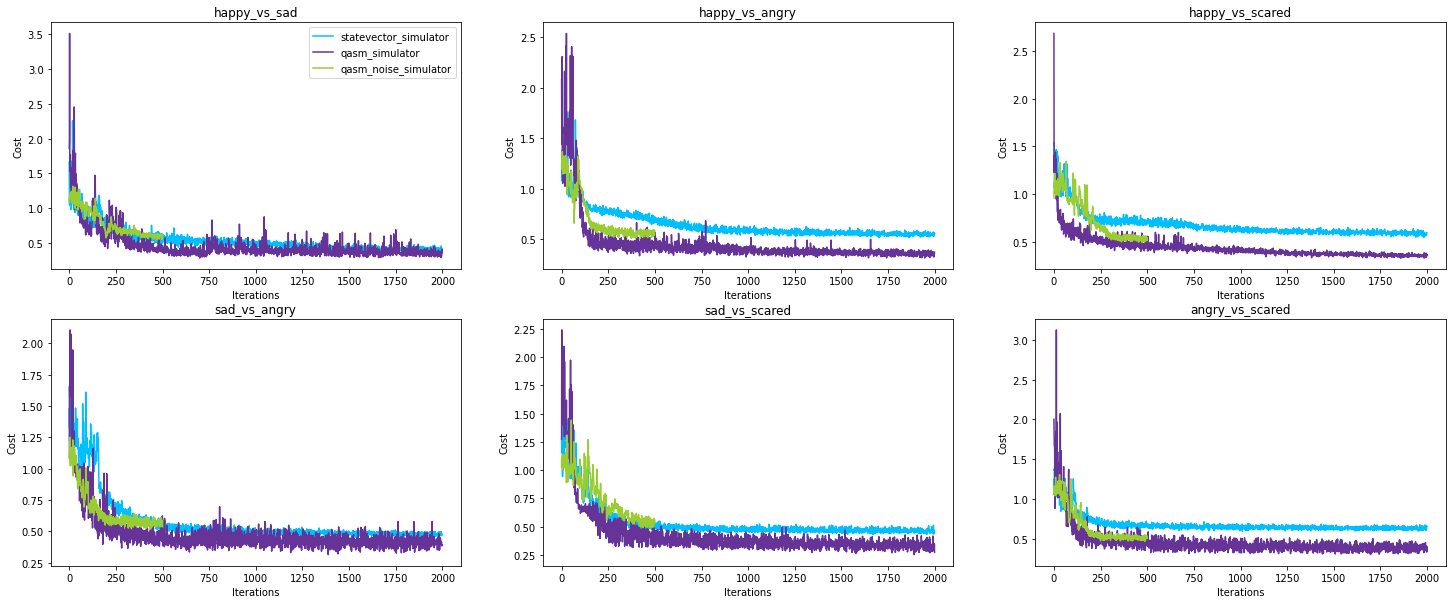

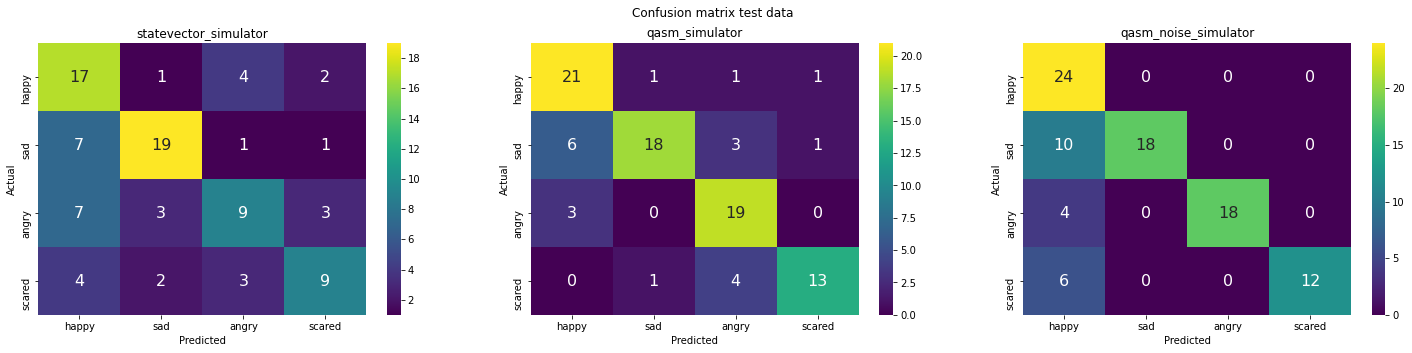

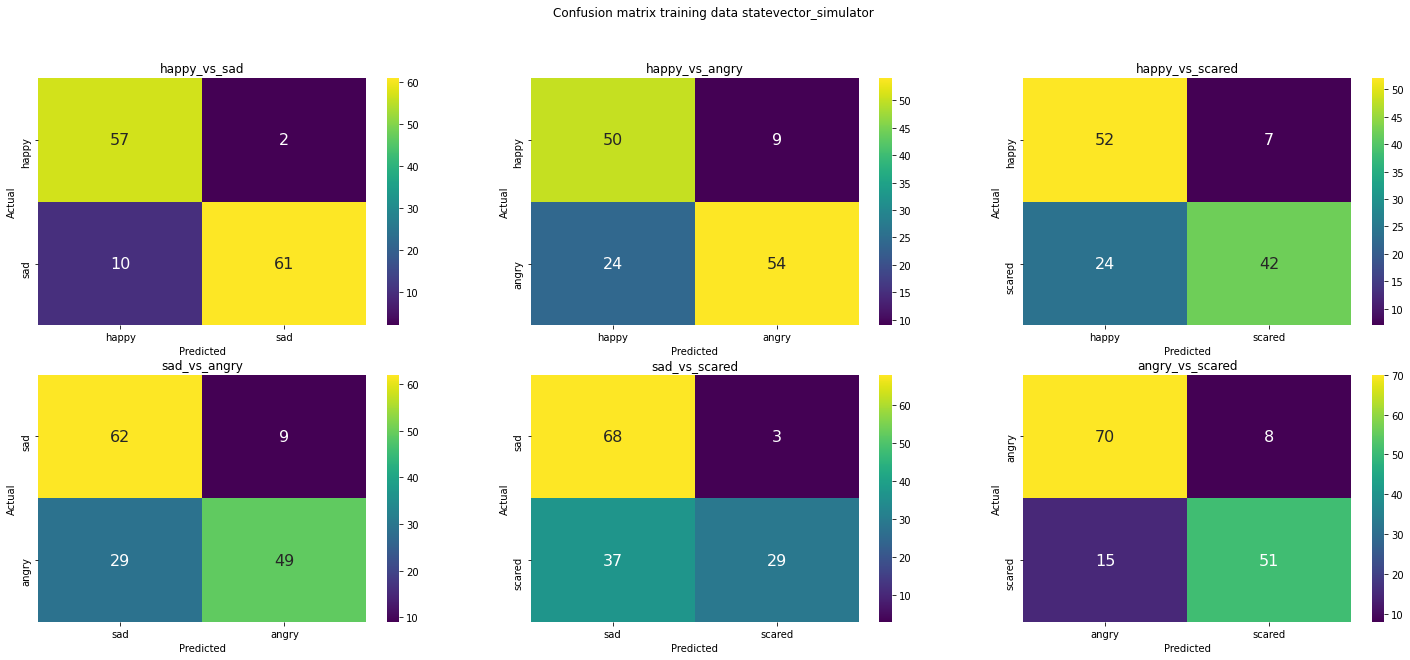

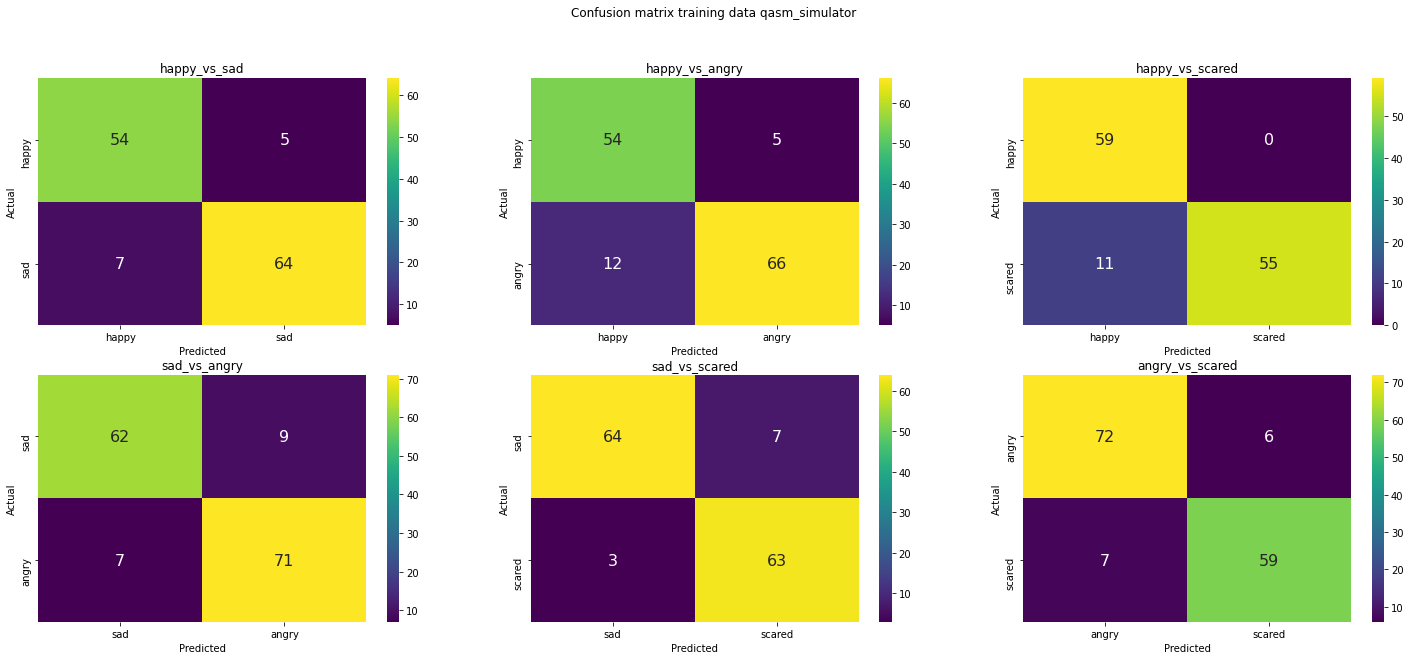

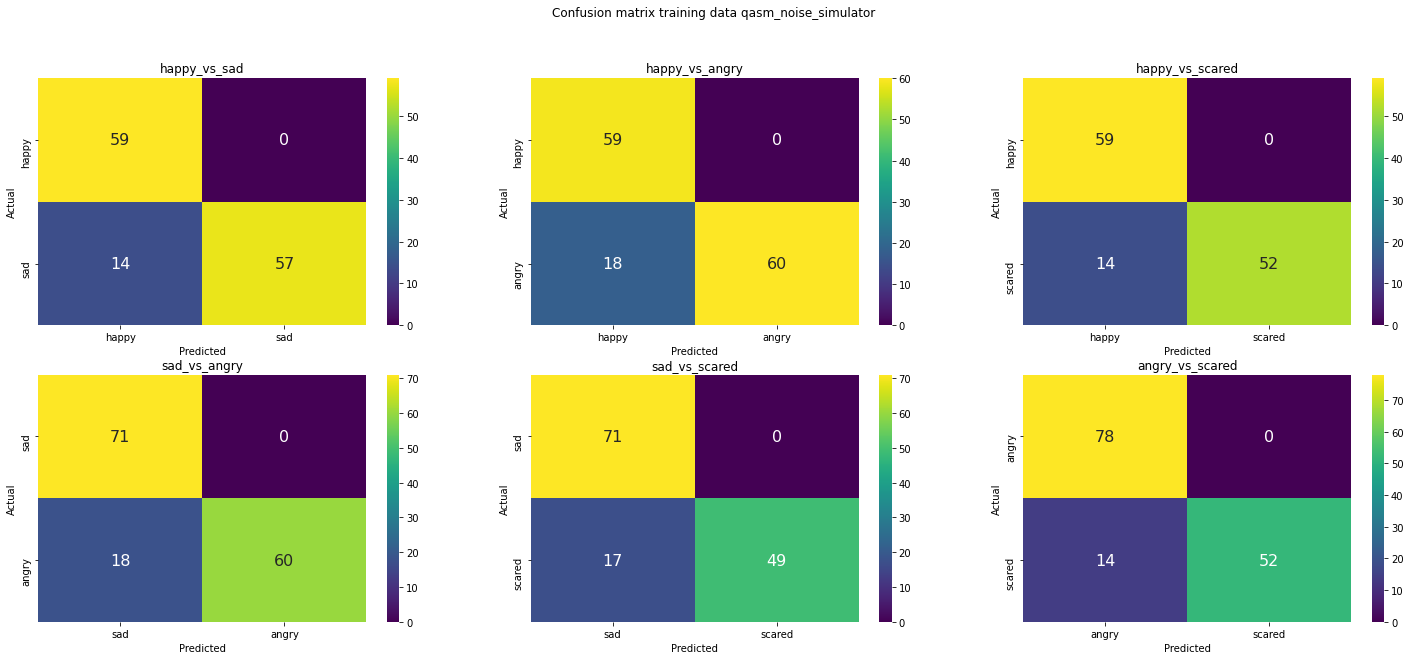

In [27]:
# Define the binary classifiers names
classifiers = ['happy_vs_sad', 'happy_vs_angry', 'happy_vs_scared', 'sad_vs_angry', 'sad_vs_scared', 'angry_vs_scared']
# Define figure for cost plot
fig, ax = plt.subplots(2,3, figsize=(25,10))
# Define figure for test confusion matrices
fig3, ax3 = plt.subplots(1,3, figsize=(25,5))
colors = ['deepskyblue','rebeccapurple','yellowgreen']
ax = ax.ravel()
noise_model = None
coupling_map = None
basis_gates= None
max_shots = 8192
# Obtain the results for the different simulators
for s, simul in enumerate(['statevector', 'qasm', 'qasm_noise']):
    if simul == 'statevector':
        niter = 2000
        qasm = False
    elif simul == 'qasm':
        niter = 2000
        qasm = True
    elif simul == 'qasm_noise':
        niter = 500
        qasm = True
        with open(f'./noise_model_melbourne.pkl', "rb") as fp:  
            data = pickle.load(fp)
        noise_model, coupling_map, basis_gates = data[0], data[1], data[2]
    # Store the training data
    final_params_cla = []
    train_data_cla = []
    train_labels_cla = []
    train_sent_cla = []
    ax = ax.ravel()
    for i, cla in enumerate(classifiers):
        results = f'./1vs1_results/sentiment_analysis_1vs1_train_{cla}_cost_entropy_niter{niter}_{simul}.pkl'
        if simul == 'qasm_noise':
            with open(results, "rb") as fp:  
                data = pickle.load(fp)
            cost, final_params = data[1], data[0][0]
        else:
            cost, final_params = get_cost_and_final_params(results)
        final_params_cla.append(final_params)
        dataset = f'./1vs1_datasets/train_{cla}.txt'
        psr_diagrams, psr_labels, sentences, _ = process_dataset(dataset)
        ax[i].plot(cost, label = f'{simul}_simulator', color = colors[s])
        ax[i].set_title(cla)
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel('Cost')
        train_data_cla.append(psr_diagrams)
        train_labels_cla.append(psr_labels)
        train_sent_cla.append(sentences)
    ax[0].legend()
    train_results_cla = obtain_train_predictions(final_params_cla,
                                                    train_data_cla, train_labels_cla, 
                                                    train_sent_cla, sent_type, qasm=qasm,
                                                    noise_model=noise_model, coupling_map=coupling_map,
                                                    basis_gates=basis_gates, max_shots=max_shots)
    final_pred_test_results = obtain_test_predictions(final_params_cla, sent_type, 
                                                    test_data_psr, test_sent, qasm=qasm,
                                                    noise_model=noise_model, coupling_map=coupling_map,
                                                    basis_gates=basis_gates, max_shots=max_shots)
    fig2, ax2 = plt.subplots(2,3, figsize=(25,10))
    ax2 = ax2.ravel()
    fig2.suptitle(f'Confusion matrix training data {simul}_simulator')
    for k, train_pred in enumerate(train_results_cla):
        y_true = [np.argmax(train_label) for train_label in train_labels_cla[k]]
        y_pred = train_pred
        c_matrix = confusion_matrix(y_true, y_pred)
        print(f'Accuracy training set {classifiers[k]} ({simul}_simulator)')
        print_accuracy(y_true, y_pred)
        labels = [classifiers[k].split('_')[0], classifiers[k].split('_')[2]]
        df_cm = pd.DataFrame(c_matrix, labels, labels)
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        sns.heatmap(df_cm, ax=ax2[k], annot=True, annot_kws={"size": 16},cmap='viridis',
                   xticklabels=True, yticklabels=True)
        ax2[k].set_title(classifiers[k])
    fig3.suptitle(f'Confusion matrix test data')
    y_true = [np.argmax(test_label) for test_label in test_labels]
    y_pred = final_pred_test_results
    c_matrix = confusion_matrix(y_true, y_pred)
    print(f'Accuracy test set ({simul}_simulator)')
    print_accuracy(y_true, y_pred)
    df_cm = pd.DataFrame(c_matrix, ['happy','sad','angry','scared'], ['happy','sad','angry','scared'])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, ax=ax3[s], annot=True, annot_kws={"size": 16},cmap='viridis',
                xticklabels=True, yticklabels=True)
    ax3[s].set_title(f'{simul}_simulator')

This is the result for just one run of the test predictions. As we are randomly assigning the labels when there are more than one most common labels, we repeat it and obtain the mean accuracy.

In [25]:
rep = 100
classifiers = ['happy_vs_sad', 'happy_vs_angry', 'happy_vs_scared', 'sad_vs_angry', 'sad_vs_scared', 'angry_vs_scared']
noise_model = None
coupling_map = None
basis_gates= None
for s, simul in enumerate(['statevector', 'qasm', 'qasm_noise']):
    if simul == 'statevector':
        niter = 2000
        qasm = False
    elif simul == 'qasm':
        niter = 2000
        qasm = True
    elif simul == 'qasm_noise':
        niter = 500
        qasm = True
        with open(f'./noise_model_melbourne.pkl', "rb") as fp:  
            data = pickle.load(fp)
        noise_model, coupling_map, basis_gates = data[0], data[1], data[2]
    final_params_cla = []
    accuracy = 0
    for i, cla in enumerate(classifiers):
        results = f'./1vs1_results/sentiment_analysis_1vs1_train_{cla}_cost_entropy_niter{niter}_{simul}.pkl'
        if simul == 'qasm_noise':
            with open(results, "rb") as fp:  
                data = pickle.load(fp)
            cost, final_params = data[1], data[0][0]
        else:
            cost, final_params = get_cost_and_final_params(results)
        final_params_cla.append(final_params)
    for i in range(rep):
        final_pred_test_results = obtain_test_predictions(final_params_cla, sent_type, 
                                                    test_data_psr, test_sent, qasm=qasm,
                                                    noise_model=noise_model, coupling_map=coupling_map,
                                                    basis_gates=basis_gates, max_shots=max_shots)
        y_true = [np.argmax(test_label) for test_label in test_labels]
        y_true = [np.argmax(test_label) for test_label in test_labels]
        y_pred = final_pred_test_results
        c_matrix = confusion_matrix(y_true, y_pred)
        accuracy += sum(np.diag(c_matrix))/len(y_true)
    print(f'Accuracy test set ({simul}_simulator) averaged over {rep} repetitions:', accuracy/rep)

Accuracy test set (statevector_simulator) averaged over 100 repetitions: 0.6338043478260866
Accuracy test set (qasm_simulator) averaged over 100 repetitions: 0.7873913043478252
Accuracy test set (qasm_noise_simulator) averaged over 100 repetitions: 0.7760869565217382


We observe that both ideal and noisy qasm simulators overcome the statevector simulator, as the intrinsic stochasticity of the quantum computer matches the SPSA optimizer. Moroever, the accuracy of the ideal and noisy qasm simulators is almost the same, showing the noise resilience of our approach. This same behaviour has already been observed in other variational quantum algorithms https://doi.org/10.1088/1367-2630/ab784c. In the future we would like to implement the algorithm in a real quantum computer, both using the cross entropy and the train error as cost functions, and also consider more ansätze and classical optimizer, in order to obtain the optimum version of the algorithm.

In [26]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.7.5', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.11.1', 'qiskit-aqua': '0.8.2', 'qiskit': '0.23.6', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}